### 기본적으로 모든 조각들에 대한 컴포넌트화가 목적

In [1]:
import os
from pprint import pprint
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import OneHotEncoder
from collections import Counter

from xgboost import XGBClassifier

#### 동일하거나 모두다른값 삭제 + OK -> NaN

In [2]:
def clean_and_save_train_data(train_data, save_filename="cleaned_train_data.csv"):
    root_dir="data"
    # 칼럼 리스트
    columns_to_clean = [
        'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam',
        'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1',
        'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2'
    ]
    #------------------------
    #동일하거나 모두다른값 삭제
    #------------------------
    train_cleaned = train_data.dropna(axis=1, how='all')
    constant_columns = [col for col in train_cleaned.columns
                        if train_cleaned[col].nunique(dropna=False) == 1]

    all_unique_columns = [col for col in train_cleaned.columns
                          if train_cleaned[col].nunique() == len(train_cleaned)]
    train_cleaned = train_cleaned.drop(columns=constant_columns)
    train_cleaned = train_cleaned.drop(columns=all_unique_columns)
    #------------------------
    # OK->NaN 변환
    #------------------------
    def replace_ok_with_nan(column):
        return column.replace('OK', np.nan)

    for col in columns_to_clean:
        if col in train_cleaned.columns:
            train_cleaned[col] = replace_ok_with_nan(train_cleaned[col])
    #------------------------
    # 저장
    #------------------------
    # 5. Save the cleaned DataFrame
    #save_path = os.path.join(root_dir, save_filename)
    #train_cleaned.to_csv(save_path, index=False)

    return train_cleaned

#### OK 결측치 이후 뒤로 밀린값 앞으로 당기기

In [3]:
import pandas as pd
from tqdm import tqdm

def adjust_and_save_dataframe(train_data, root_dir, save_filename="cleaned.csv"):
    root_dir = "data"
    rows = train_data.shape[0]

    # tqdm을 사용하여 진행 상황 표시
    for i in tqdm(range(0, rows), desc="Adjusting DataFrame"):
        if pd.isna(train_data.iloc[i, 16]):
            train_data.iloc[i, 16] = train_data.iloc[i, 18]
            temp_values = train_data.iloc[i, 18:69].values
            train_data.iloc[i, 18:68] = temp_values[1:]
            train_data.iloc[i, 69] = None
        if pd.isna(train_data.iloc[i, 93]):
            train_data.iloc[i, 93] = train_data.iloc[i, 95]
            temp_values = train_data.iloc[i, 95:116].values
            train_data.iloc[i, 95:115] = temp_values[1:]
            train_data.iloc[i, 116] = None
        if pd.isna(train_data.iloc[i, 126]):
            train_data.iloc[i, 126] = train_data.iloc[i, 128]
            temp_values = train_data.iloc[i, 128:149].values
            train_data.iloc[i, 128:148] = temp_values[1:]
            train_data.iloc[i, 149] = None
    
    # 밀린 맨끝값들 없애기
    train_data = train_data.drop(train_data.columns[[149, 116, 69]], axis=1)

    # 저장 (현재는 주석 처리됨)
    # save_path = os.path.join(root_dir, save_filename)
    # train_data.to_csv(save_path, index=False)

    return train_data

#### 통계량 확인

In [4]:
def calculate_statistics(dataframe):
    statistics = dataframe.describe()
    return statistics

#### 이상치, 결측치, Outlier

In [5]:
import numpy as np
from scipy import stats

def analyze_and_handle_missing_data(df):
    # nan확인
    nan_counts = df.isna().sum()
    nan_counts_with_nan = nan_counts[nan_counts > 0]

    # 결측치출력
    for column, count in nan_counts_with_nan.items():
        print(f"{column}: {count}개의 결측치")
        print(f"{column}: {df[column].dtype}")
        print(df[column].value_counts())  # Print non-NaN value counts

    # 결측치 평균으로 대체
    #for column in nan_counts_with_nan.index:
    #    if df[column].dtype in [np.float64, np.int64]:  # Only fill for numeric columns
    #        df[column].fillna(df[column].mean(), inplace=True)

    # outlier
    def detect_outliers_zscore(data):
        z_scores = np.abs(stats.zscore(data))
        return z_scores > 3

    for column in df.select_dtypes(include=[np.number]).columns:
        # Detect outliers using Z-score
        outliers_zscore = detect_outliers_zscore(df[column])
        print(f"Column {column} has {outliers_zscore.sum()} outliers detected by Z-score")
        # Histogram visualization
        #plt.figure(figsize=(10, 6))
        
        # Overall data histogram visualization
        #sns.histplot(df[column], kde=True, color='lightblue', label='Data', bins=30)
        
        # Outliers data histogram visualization
        #sns.histplot(df.loc[outliers_zscore, column], kde=True, color='red', label='Z-score Outliers', bins=30)
        
        #plt.title(f'Z-score Outliers Detection in {column}')
        #plt.legend()
        #plt.show()

    return df

# Example usage:
# cleaned_df = analyze_and_handle_missing_data(your_dataframe)


#### 인코딩

#####  num_columns,columns_to_convert

In [6]:
# 숫자 데이터(int, float)로 이루어진 열 중 원핫인코딩 대상
num_columns = [
    'CURE END POSITION X Collect Result_Dam',
    'CURE END POSITION Z Collect Result_Dam',
    'CURE END POSITION Θ Collect Result_Dam',
    'CURE START POSITION X Collect Result_Dam',
    'CURE START POSITION Θ Collect Result_Dam',
    'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam', 
    'HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Dam',
    'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam',
    'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam',
    'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam',
    'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam',
    'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Dam',
    'HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Dam',
    'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Dam',
    'HEAD Standby Position X Collect Result_Dam',
    'HEAD Standby Position Y Collect Result_Dam',
    'HEAD Standby Position Z Collect Result_Dam',
    'Head Clean Position X Collect Result_Dam',
    'Head Clean Position Y Collect Result_Dam',
    'Head Clean Position Z Collect Result_Dam',
    'Head Purge Position X Collect Result_Dam',
    'Head Purge Position Y Collect Result_Dam',
    'Head Purge Position Z Collect Result_Dam',
    'Head Zero Position X Collect Result_Dam',
    'Head Zero Position Y Collect Result_Dam',
    'Head Zero Position Z Collect Result_Dam',
    'PalletID Collect Result_Dam',
    'Receip No Collect Result_Dam',
    'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1', 
    'HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill1',
    'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill1',
    'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1',
    'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill1',
    'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill1',
    'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill1',
    'HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill1',
    'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Fill1',
    'HEAD Standby Position X Collect Result_Fill1',
    'HEAD Standby Position Y Collect Result_Fill1',
    'HEAD Standby Position Z Collect Result_Fill1',
    'Head Clean Position X Collect Result_Fill1',
    'Head Clean Position Y Collect Result_Fill1',
    'Head Clean Position Z Collect Result_Fill1',
    'Head Purge Position X Collect Result_Fill1',
    'Head Purge Position Y Collect Result_Fill1',
    'Head Purge Position Z Collect Result_Fill1',
    'PalletID Collect Result_Fill1',
    'Receip No Collect Result_Fill1',
    'CURE END POSITION X Collect Result_Fill2',
    'CURE END POSITION Z Collect Result_Fill2',
    # 'CURE END POSITION Θ Collect Result_Fill2', 값이 모든 열 제거에서 제거됨이 확인
    'CURE STANDBY POSITION Z Collect Result_Fill2',
    'CURE START POSITION X Collect Result_Fill2',
    'CURE START POSITION Z Collect Result_Fill2',
    'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2', 
    'HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill2',
    'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill2',
    'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill2',
    'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill2',
    'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill2',
    'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill2',
    'HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill2',
    'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Fill2',
    'HEAD Standby Position X Collect Result_Fill2',
    'HEAD Standby Position Y Collect Result_Fill2',
    'HEAD Standby Position Z Collect Result_Fill2',
    'Head Clean Position X Collect Result_Fill2',
    'Head Clean Position Y Collect Result_Fill2',
    'Head Clean Position Z Collect Result_Fill2',
    'Head Purge Position X Collect Result_Fill2',
    'Head Purge Position Y Collect Result_Fill2',
    'Head Purge Position Z Collect Result_Fill2',
    'PalletID Collect Result_Fill2',
    'Receip No Collect Result_Fill2',
]
columns_to_convert = [
        'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam',
        'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1',
        'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2'
    ]

##### 이게 함수

In [7]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler

# OneHotEncoder 정의
encoder = OneHotEncoder(drop='first', sparse_output=False, dtype=int, handle_unknown='ignore')


def encode_and_transformation_train(df, num_columns=num_columns, columns_to_convert=columns_to_convert):
    # 1. 지정된 열들을 숫자형으로 변환
    for col in columns_to_convert:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    # 2. Object 열들에 대한 인코딩 수행
    object_columns = df.select_dtypes(include=['object']).columns.tolist()
    # 라벨인코딩
    # label_encoders = {}
    # for col in object_columns:
    #     if col=="target":
    #         print("not Target Column.")
    #         continue
    #     le = LabelEncoder()
    #     df[col] = le.fit_transform(df[col].astype(str))
    #     label_encoders[col] = le
    
    # 원핫인코딩 - 위의 라벨 인코딩이랑 둘중 하나는 주석 걸어주셔야 합니다~
    columns_to_encode = [col for col in object_columns if col != 'target']

    # 원핫 인코딩 수행 (훈련 데이터에 맞추어 인코딩 수행)
    train_encoded = encoder.fit_transform(df[columns_to_encode])

    # 인코딩된 열의 이름을 가져옴 (OneHotEncoder는 자동으로 새로운 열 이름을 생성하지 않으므로 수동으로 관리해야 함)
    encoded_columns = encoder.get_feature_names_out(columns_to_encode)

    # DataFrame으로 변환
    train_cleaned_encoded = pd.DataFrame(train_encoded, columns=encoded_columns)

    # train_cleaned_encoded에 원래의 다른 열 추가
    train_cleaned_encoded = pd.concat([df.drop(columns=columns_to_encode).reset_index(drop=True), train_cleaned_encoded], axis=1)

    print("One-hot encoding completed.")

    # 3. 숫자형 열 정규화
    if num_columns:
        scaler = StandardScaler()
        train_cleaned_encoded[num_columns] = scaler.fit_transform(train_cleaned_encoded[num_columns])
    return train_cleaned_encoded, columns_to_encode, encoded_columns

def encode_and_transformation_test(df, columns_to_encode, encoded_columns, num_columns=num_columns, columns_to_convert=columns_to_convert):
    # 1. 지정된 열들을 숫자형으로 변환
    for col in columns_to_convert:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    
    # test 데이터 원핫 인코딩
    test_encoded = encoder.transform(df[columns_to_encode])

    # DataFrame으로 변환
    test_data_encoded = pd.DataFrame(test_encoded, columns=encoded_columns)

    # test_data_encoded에 원래의 다른 열 추가
    test_data_encoded = pd.concat([df.drop(columns=columns_to_encode).reset_index(drop=True), test_data_encoded], axis=1)

    print("One-hot encoding completed.")

    # 3. 숫자형 열 정규화
    if num_columns:
        scaler = StandardScaler()
        test_data_encoded[num_columns] = scaler.fit_transform(test_data_encoded[num_columns])
    return test_data_encoded

#### 언더샘플링 함수

In [8]:
import pandas as pd

def undersample_data(df, normal_ratio=1.0, random_state=None):
    # 정상 및 비정상 클래스를 분리
    df_normal = df[df["target"] == "Normal"]
    df_abnormal = df[df["target"] == "AbNormal"]

    # 각 클래스의 샘플 수를 확인
    num_normal = len(df_normal)
    num_abnormal = len(df_abnormal)
    
    print(f"Normal samples: {df_normal.shape}, AbNormal samples: {df_abnormal.shape}")
    print(f"Total: Normal: {num_normal}, AbNormal: {num_abnormal}")

    if num_abnormal == 0 or num_normal == 0:
        raise ValueError("One of the classes has no samples, check the data for issues.")
    
    # 정상 클래스를 비정상 클래스와 동일한 비율로 언더샘플링
    df_normal = df_normal.sample(n=int(num_abnormal * normal_ratio), replace=False, random_state=random_state)

    # 언더샘플링된 정상 클래스와 비정상 클래스를 결합
    df_balanced = pd.concat([df_normal, df_abnormal], axis=0).reset_index(drop=True)

    # 최종 통계 정보 출력
    num_normal_balanced = len(df_balanced[df_balanced["target"] == "Normal"])
    num_abnormal_balanced = len(df_balanced[df_balanced["target"] == "AbNormal"])
    print(f"Balanced data: Normal: {num_normal_balanced}, AbNormal: {num_abnormal_balanced}" + f" ratio: {num_abnormal_balanced/num_normal_balanced:.2f}")

    return df_balanced

# 사용 예시:
# df_balanced = undersample_data(train_cleaned_encoded, random_state=110)


#### 오버샘플링 함수

In [9]:
from imblearn.over_sampling import SMOTE
import pandas as pd

def oversample_data(df, normal_ratio=1.0, random_state=None):
    # 정상 및 비정상 클래스를 분리
    df_normal = df[df["target"] == "Normal"]
    df_abnormal = df[df["target"] == "AbNormal"]
    print(df["target"])
    
    # 각 클래스의 샘플 수를 확인
    num_normal = len(df_normal)
    num_abnormal = len(df_abnormal)
    
    print(f"Normal samples: {df_normal.shape}, AbNormal samples: {df_abnormal.shape}")
    print(f"Total: Normal: {num_normal}, AbNormal: {num_abnormal}")

    if num_abnormal == 0 or num_normal == 0:
        raise ValueError("One of the classes has no samples, check the data for issues.")
    
    # 오버샘플링: SMOTE를 사용하여 소수 클래스를 증강
    smote = SMOTE(sampling_strategy=normal_ratio, random_state=random_state)
    X = df.drop(columns=["target"])
    y = df["target"]
    
    X_resampled, y_resampled = smote.fit_resample(X, y)
    
    # 오버샘플링된 데이터를 다시 결합
    df_resampled = pd.concat([X_resampled, y_resampled], axis=1)
    
    # 통계 정보 출력 함수
    def print_stats(df: pd.DataFrame):
        num_normal = len(df[df["target"] == "Normal"])
        num_abnormal = len(df[df["target"] == "AbNormal"])
        print(f"Total: Normal: {num_normal}, AbNormal: {num_abnormal}" + f" ratio: {num_abnormal/num_normal:.2f}")

    print("Resampled data stats:")
    print_stats(df_resampled)

    return df_resampled

# 사용 예시:
# df_resampled = oversample_data(train_cleaned_encoded, random_state=110)

#### 전처리, 학습, 테스트데이터 예측함수

In [10]:
# 데이터 전처리 함수
def preprocess_data(train_data, test_data, ROOT_DIR):
    train_cleaned = clean_and_save_train_data(train_data, ROOT_DIR)
    test_cleaned = clean_and_save_train_data(test_data, ROOT_DIR)  
    print("Data cleaning completed")

    train_cleaned = adjust_and_save_dataframe(train_cleaned, ROOT_DIR)
    test_cleaned = adjust_and_save_dataframe(test_cleaned, ROOT_DIR)  
    print("Data adjustment completed")

    stats = calculate_statistics(train_cleaned)
    print("Statistics calculation completed")
    print(stats)

    train_encoded, columns_to_encode, encoded_columns = encode_and_transformation_train(train_cleaned)
    test_encoded = encode_and_transformation_test(test_cleaned, columns_to_encode, encoded_columns)  
    print("Data encoding and transformation completed")

    return train_encoded, test_encoded


In [11]:
# 모델 학습 함수
def train_model(df_train, RANDOM_STATE):
    model = XGBClassifier(random_state=RANDOM_STATE, eval_metric='mlogloss')
    features = []

    # 피처 선택 및 타입 변환
    for col in df_train.columns:
        if col != 'target':  # 'target' 열 제외
            try:
                df_train[col] = df_train[col].astype(int)  # 타입 변환 시도
                features.append(col)  # 성공적으로 변환된 피처 추가
            except:
                continue  # 변환 실패 시 무시

    train_x = df_train[features]
    train_y = df_train["target"]

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    accuracy_scores = cross_val_score(model, train_x, train_y, cv=skf, scoring='accuracy')
    f1_scores = cross_val_score(model, train_x, train_y, cv=skf, scoring='f1_macro')
    precision_scores = cross_val_score(model, train_x, train_y, cv=skf, scoring='precision_macro')

    print(f"정확도: {np.mean(accuracy_scores):.4f}")
    print(f"정밀도: {np.mean(precision_scores):.4f}")
    print(f"F1스코어: {np.mean(f1_scores):.4f}")
    print("Model training completed")

    # 모델 학습
    model.fit(train_x, train_y)
    return model, features

In [12]:
# 테스트 데이터 예측 및 결과 저장 함수
def predict_and_save_results(model, test_encoded, features):
    # 테스트 데이터 준비
    df_test_x = test_encoded[features]

    # 타입 변환
    for col in df_test_x.columns:
        try:
            df_test_x[col] = df_test_x[col].astype(int)
        except:
            continue

    # 테스트 데이터 예측
    test_pred = model.predict(df_test_x)
    print("Test data prediction completed")

    # Feature importance plot
    ftr_importances_values = model.feature_importances_
    ftr_importances = pd.Series(ftr_importances_values, index=features)
    ftr_top30 = ftr_importances.sort_values(ascending=False)[:30]

    plt.figure(figsize=(8, 6))
    plt.title('Top 30 Feature Importances')
    sns.barplot(x=ftr_top30, y=ftr_top30.index)
    plt.show()
    print("Feature importance plotting completed")

    # Count predictions
    count = Counter(test_pred)
    for element, frequency in count.items():
        print(f'Element: {element}, Count: {frequency}')

    # Predict probabilities
    proba = model.predict_proba(df_test_x)
    print(proba)

    # 결과 저장
    df_sub = pd.read_csv("submission.csv")
    df_sub["target"] = test_pred
    df_sub.to_csv("submission.csv", index=False)
    print("Submission file saved")

In [13]:
ROOT_DIR = "data"
RANDOM_STATE = 110

#데이터 전처리
train_data = pd.read_csv(os.path.join(ROOT_DIR, "train.csv"))
test_data = pd.read_csv(os.path.join(ROOT_DIR, "test.csv"))
print("Data loading completed")
print(f"Train data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")


train_encoded, test_encoded = preprocess_data(train_data, test_data, ROOT_DIR)

print(f"Encoded train data shape: {train_encoded.shape}")
print(f"Encoded test data shape: {test_encoded.shape}")


Data loading completed
Train data shape: (40506, 464)
Test data shape: (17361, 465)
Data cleaning completed


Adjusting DataFrame:   0%|          | 0/40506 [00:00<?, ?it/s]C:\Users\1233d\AppData\Local\Temp\ipykernel_32684\3787398044.py:23: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '114.612' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  train_data.iloc[i, 128:148] = temp_values[1:]
C:\Users\1233d\AppData\Local\Temp\ipykernel_32684\3787398044.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.012' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  train_data.iloc[i, 18:68] = temp_values[1:]
Adjusting DataFrame:   0%|          | 0/17361 [00:00<?, ?it/s]C:\Users\1233d\AppData\Local\Temp\ipykernel_32684\3787398044.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-

Data adjustment completed
Statistics calculation completed
       CURE END POSITION X Collect Result_Dam  \
count                            40506.000000   
mean                               530.370809   
std                                369.283055   
min                                240.000000   
25%                                240.000000   
50%                                240.000000   
75%                               1000.000000   
max                               1000.000000   

       CURE END POSITION Z Collect Result_Dam  \
count                            40506.000000   
mean                                 6.320669   
std                                  4.858988   
min                                  2.500000   
25%                                  2.500000   
50%                                  2.500000   
75%                                 12.500000   
max                                 12.500000   

       CURE END POSITION Θ Collect Result_Dam  CURE SPEED

c:\Users\1233d\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [2, 5, 11, 15] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


One-hot encoding completed.
Data encoding and transformation completed
Encoded train data shape: (40506, 2812)
Encoded test data shape: (17361, 2811)


0          Normal
1          Normal
2          Normal
3          Normal
4          Normal
           ...   
40501      Normal
40502      Normal
40503      Normal
40504      Normal
40505    AbNormal
Name: target, Length: 40506, dtype: object
Normal samples: (38156, 2812), AbNormal samples: (2350, 2812)
Total: Normal: 38156, AbNormal: 2350
Resampled data stats:
Total: Normal: 38156, AbNormal: 38156 ratio: 1.00
Train set shape: (76312, 2812)
정확도: 0.8528
정밀도: 0.8541
F1스코어: 0.8526
Model training completed
Test data prediction completed


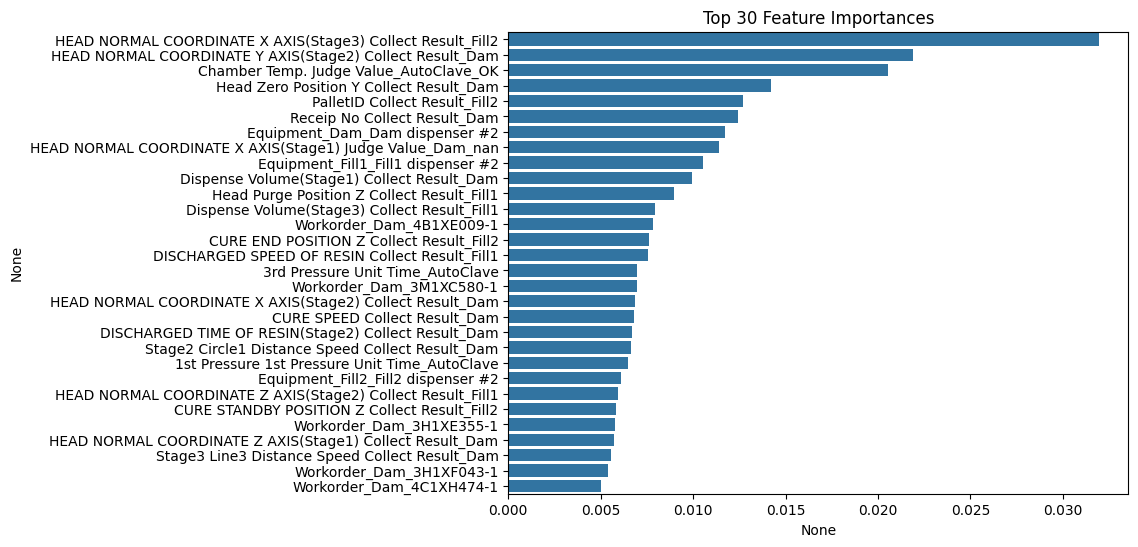

Feature importance plotting completed
Element: 1, Count: 14850
Element: 0, Count: 2511
[[0.44433862 0.5556614 ]
 [0.16771895 0.83228105]
 [0.2529121  0.7470879 ]
 ...
 [0.37371618 0.6262838 ]
 [0.18198287 0.8180171 ]
 [0.45203036 0.54796964]]
Submission file saved


In [14]:
# 모델 학습
df_train = oversample_data(train_encoded, random_state=RANDOM_STATE)

#XGBoost는 target 칼럼도 인코딩 필요
# 레이블 인코더 생성
label_encoder = LabelEncoder()    
# 레이블 변환
df_train['target'] = label_encoder.fit_transform(df_train['target'])

print(f"Train set shape: {df_train.shape}")

model, features = train_model(df_train, RANDOM_STATE)

# 테스트 데이터 예측 및 결과 저장
predict_and_save_results(model, test_encoded, features)


submission.csv에서 target이 1이면 Normal, 0이면 AbNormal로 변환

In [16]:
# 파일 경로 설정
file_path = 'submission.csv'

# submission.csv 파일 읽기
df = pd.read_csv(file_path)

# 'target' 열의 값을 1은 'Normal', 0은 'AbNormal'로 변환
df['target'] = df['target'].map({1: 'Normal', 0: 'AbNormal'})

# 변환된 DataFrame을 원본 CSV 파일에 덮어쓰기
df.to_csv(file_path, index=False)

print("변환 완료")

변환 완료
